In [1]:

#pip install lightgbm 
#pip install xgboost


In [2]:

import  matplotlib.pyplot as plt
import pandas as pd
import datetime


import lightgbm as lgb
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,roc_curve,auc,roc_auc_score,mean_squared_error
from sklearn.model_selection import train_test_split
import toad

pd.set_option("display.max_columns",50)

train_bank = pd.read_csv('./train_public.csv')

print(train_bank.shape)
train_bank.head()

(10000, 39)


,loan_id,user_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,censor_status,issue_date,use,post_code,region,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,known_outstanding_loan,known_dero,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,app_type,earlies_credit_mon,title,policy_code,f0,f1,f2,f3,f4,early_return,early_return_amount,early_return_amount_3mon,isDefault
0,1040418,240418,31818.18182,3,11.466,1174.91,C,政府机构,金融业,3 years,0,1,2016/10/1,2,193,13,2.430000,0,556.363636,649.090909,3,0,0.0,7734.230769,91.800000,0,0,1-Dec,5,1,1.0,0.0,4.0,5.0,4.0,3,9927,0.0,0
1,1025197,225197,28000.00000,5,16.841,670.69,C,政府机构,金融业,10+ years,0,2,2013/6/1,0,491,30,11.004545,1,715.000000,893.750000,3,0,0.0,31329.000000,54.800000,1,0,Apr-90,40642,1,7.0,0.0,4.0,45.0,22.0,0,0,0.0,0
2,1009360,209360,17272.72727,3,8.900,603.32,A,政府机构,公共服务、社会组织,10+ years,1,0,2014/1/1,4,459,8,6.409091,0,774.545455,903.636364,5,0,0.0,18514.000000,57.692308,1,0,Oct-91,154,1,6.0,0.0,6.0,28.0,19.0,0,0,0.0,0
3,1039708,239708,20000.00000,3,4.788,602.30,A,世界五百强,文化和体育业,6 years,0,1,2015/7/1,0,157,8,9.204545,0,750.000000,875.000000,3,0,0.0,20707.000000,42.600000,0,0,1-Jun,0,1,5.0,0.0,10.0,15.0,9.0,0,0,0.0,0
4,1027483,227483,15272.72727,3,12.790,470.31,C,政府机构,信息传输、软件和信息技术服务业,< 1 year,2,1,2016/7/1,0,38,21,15.578182,0,609.090909,710.606061,15,0,0.0,14016.153850,30.461538,0,0,2-May,0,1,10.0,0.0,6.0,15.0,4.0,0,0,0.0,0


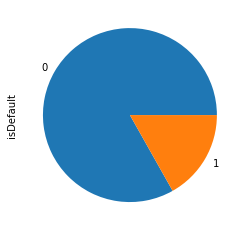

In [3]:
## 好坏样本的占比
train_bank.isDefault.value_counts().plot(kind='pie')


## 数据预处理

In [4]:
# 日期类型：issueDate 转换为pandas中的日期类型，加工出数值特征
train_bank['issue_date'] = pd.to_datetime(train_bank['issue_date'])
# 提取多尺度特征
train_bank['issue_date_y'] = train_bank['issue_date'].dt.year
train_bank['issue_date_m'] = train_bank['issue_date'].dt.month
# 提取时间diff # 转换为天为单位
base_time = datetime.datetime.strptime('2000-01-01', '%Y-%m-%d')   # 随机设置初始的基准时间
train_bank['issue_date_diff'] = train_bank['issue_date'].apply(lambda x: x-base_time).dt.days
# 可以发现earlies_credit_mon应该是年份-月的格式，这里简单提取年份
train_bank['earlies_credit_mon'] = train_bank['earlies_credit_mon'].map(lambda x:int(sorted(x.split('-'))[0]))
train_bank.head()

,loan_id,user_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,censor_status,issue_date,use,post_code,region,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,known_outstanding_loan,known_dero,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,app_type,earlies_credit_mon,title,policy_code,f0,f1,f2,f3,f4,early_return,early_return_amount,early_return_amount_3mon,isDefault,issue_date_y,issue_date_m,issue_date_diff
0,1040418,240418,31818.18182,3,11.466,1174.91,C,政府机构,金融业,3 years,0,1,2016-10-01,2,193,13,2.430000,0,556.363636,649.090909,3,0,0.0,7734.230769,91.800000,0,0,1,5,1,1.0,0.0,4.0,5.0,4.0,3,9927,0.0,0,2016,10,6118
1,1025197,225197,28000.00000,5,16.841,670.69,C,政府机构,金融业,10+ years,0,2,2013-06-01,0,491,30,11.004545,1,715.000000,893.750000,3,0,0.0,31329.000000,54.800000,1,0,90,40642,1,7.0,0.0,4.0,45.0,22.0,0,0,0.0,0,2013,6,4900
2,1009360,209360,17272.72727,3,8.900,603.32,A,政府机构,公共服务、社会组织,10+ years,1,0,2014-01-01,4,459,8,6.409091,0,774.545455,903.636364,5,0,0.0,18514.000000,57.692308,1,0,91,154,1,6.0,0.0,6.0,28.0,19.0,0,0,0.0,0,2014,1,5114
3,1039708,239708,20000.00000,3,4.788,602.30,A,世界五百强,文化和体育业,6 years,0,1,2015-07-01,0,157,8,9.204545,0,750.000000,875.000000,3,0,0.0,20707.000000,42.600000,0,0,1,0,1,5.0,0.0,10.0,15.0,9.0,0,0,0.0,0,2015,7,5660
4,1027483,227483,15272.72727,3,12.790,470.31,C,政府机构,信息传输、软件和信息技术服务业,< 1 year,2,1,2016-07-01,0,38,21,15.578182,0,609.090909,710.606061,15,0,0.0,14016.153850,30.461538,0,0,2,0,1,10.0,0.0,6.0,15.0,4.0,0,0,0.0,0,2016,7,6026


In [5]:
train_bank['employer_type'].value_counts()

普通企业       4610
政府机构       2474
幼教与中小学校    1053
上市企业        958
世界五百强       542
高等教育机构      363
Name: employer_type, dtype: int64

In [6]:
train_bank['industry'].value_counts()

金融业                1629
电力、热力生产供应业         1248
公共服务、社会组织          1065
住宿和餐饮业              907
信息传输、软件和信息技术服务业     808
文化和体育业              793
建筑业                 704
房地产业                554
采矿业                 506
交通运输、仓储和邮政业         492
农、林、牧、渔业            466
制造业                 302
批发和零售业              279
国际组织                247
Name: industry, dtype: int64

In [7]:
# 工作年限处理
train_bank['work_year'].fillna('10+ years', inplace=True)

work_year_map = {'10+ years': 10, '2 years': 2, '< 1 year': 0, '3 years': 3, '1 year': 1,
     '5 years': 5, '4 years': 4, '6 years': 6, '8 years': 8, '7 years': 7, '9 years': 9}
train_bank['work_year']  = train_bank['work_year'].map(work_year_map)

train_bank['class'] = train_bank['class'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6})

# 缺失值处理
train_bank = train_bank.fillna('9999')

In [8]:
# 区分 数值 或类别特征

drop_list = ['isDefault','earlies_credit_mon','loan_id','user_id','issue_date']
num_feas = []
cate_feas = []

for col in train_bank.columns:
    if col not in drop_list:
        try:
            train_bank[col] = pd.to_numeric(train_bank[col]) # 转为数值
            num_feas.append(col)
        except:
            train_bank[col] = train_bank[col].astype('category')
            cate_feas.append(col)
            
print(cate_feas)
print(num_feas)


['employer_type', 'industry']
['total_loan', 'year_of_loan', 'interest', 'monthly_payment', 'class', 'work_year', 'house_exist', 'censor_status', 'use', 'post_code', 'region', 'debt_loan_ratio', 'del_in_18month', 'scoring_low', 'scoring_high', 'known_outstanding_loan', 'known_dero', 'pub_dero_bankrup', 'recircle_b', 'recircle_u', 'initial_list_status', 'app_type', 'title', 'policy_code', 'f0', 'f1', 'f2', 'f3', 'f4', 'early_return', 'early_return_amount', 'early_return_amount_3mon', 'issue_date_y', 'issue_date_m', 'issue_date_diff']


## 选择模型 LigthGBM

lgb树模型是集成学习的强模型，自带缺失、类别变量的处理，特征上面不用做很多处理，建模非常方便。

In [9]:

def model_metrics(model, x, y):
    """ 评估 """
    yprob = model.predict(x)
    fpr,tpr,_ = roc_curve(y, yprob,pos_label=1)
    metrics = {'AUC':auc(fpr, tpr),'KS':max(tpr-fpr)}
    
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)

    plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')  # 可以使用中文，但需要导入一些库即字体
    plt.title('ROC Curve')
    plt.legend(loc="lower right")


    return metrics


In [10]:
# 划分数据集：训练集和测试集
train_x, test_x, train_y, test_y = train_test_split(train_bank[num_feas + cate_feas], train_bank.isDefault,test_size=0.3, random_state=0)

# 训练集再划分新旧的训练集，新的训练集用增量学习方法进行学习
trainold_x, trainnew_x, trainold_y, trainnew_y = train_test_split(train_x, train_y,test_size=0.5, random_state=0)


lgb_train = lgb.Dataset(trainold_x, trainold_y)
lgb_newtrain = lgb.Dataset(trainnew_x, trainnew_y)
lgb_eval = lgb.Dataset(test_x,test_y, reference=lgb_train)


[LightGBM] [Info] Number of positive: 602, number of negative: 2898
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3371
[LightGBM] [Info] Number of data points in the train set: 3500, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.172000 -> initscore=-1.571519
[LightGBM] [Info] Start training from score -1.571519
train  {'AUC': 0.8696629477540933, 'KS': 0.6470059543871476}
test  {'AUC': 0.8458304576799567, 'KS': 0.6284431987999525}


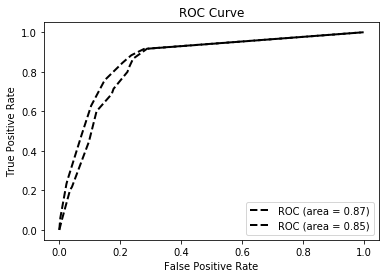

In [19]:
# 参数
params = {
    'task': 'train',
    'boosting_type': 'gbdt',  # 设置提升类型
    'objective': 'binary',  # 目标函数
    'metric': {'l2', 'auc'},  # 评估函数
    'num_leaves': 12,  # 叶子节点数
    'learning_rate': 0.05,  # 学习速率
    'feature_fraction': 0.9,  # 建树的特征选择比例
    'bagging_fraction': 0.8,  # 建树的样本采样比例
    'verbose': 1  
}
 
# 模型训练
gbm = lgb.train(params, lgb_train, num_boost_round=1)

print('train ',model_metrics(gbm,trainold_x, trainold_y))
print('test ',model_metrics(gbm,test_x,test_y))

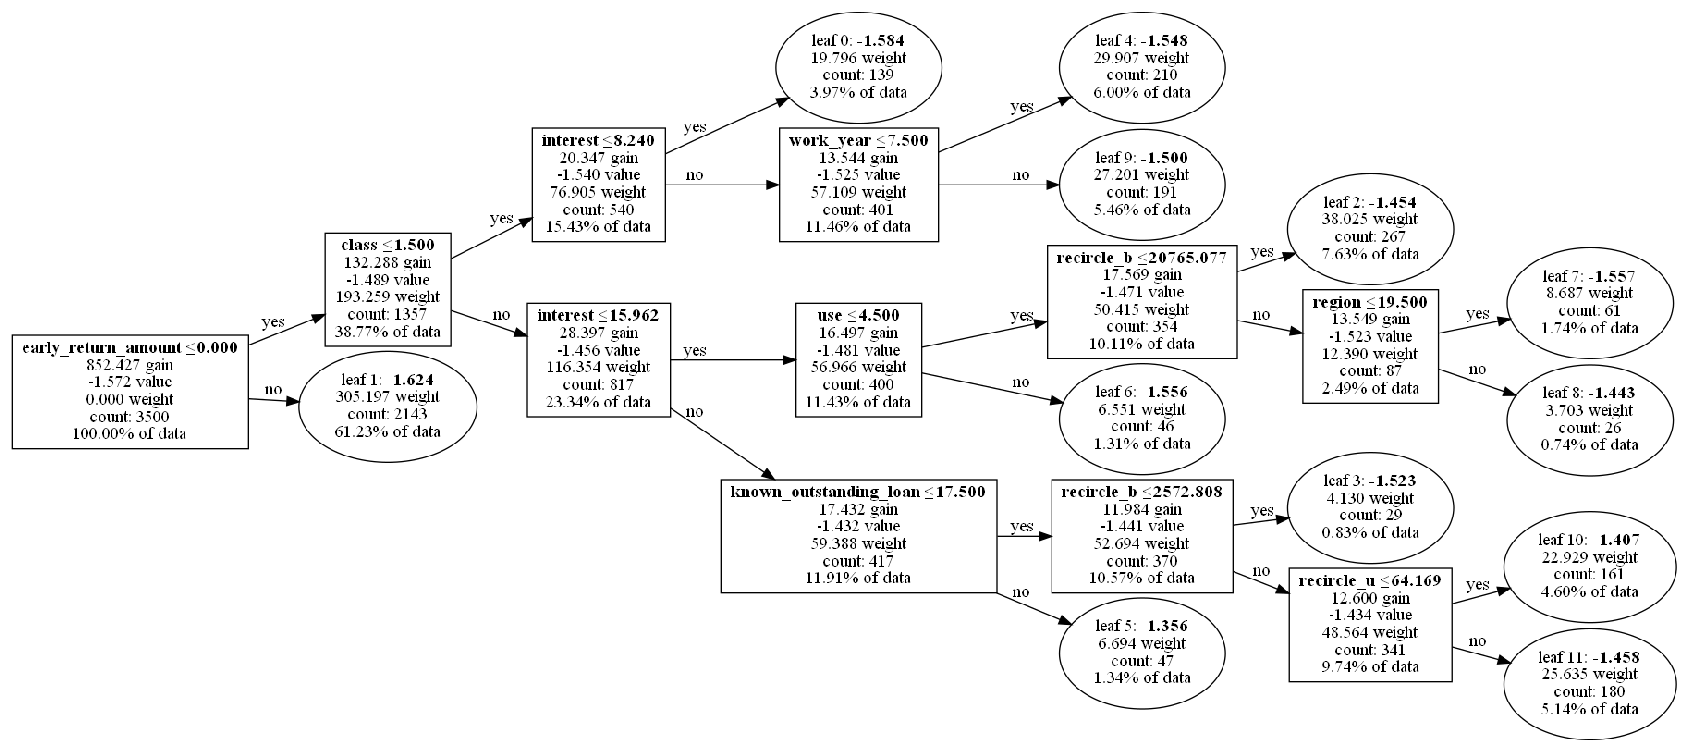

In [13]:
# 树模型决策的可视化


# 需要先安装https://graphviz.org/download/
import os
os.environ["PATH"] += os.pathsep + 'D:/Program Files/Graphviz/bin/'

for k in range(1):
    ax = lgb.plot_tree(gbm, tree_index=k, figsize=(30,20), show_info=['split_gain','internal_value','internal_count','internal_weight','leaf_count','leaf_weight','data_percentage'])
plt.show()

In [15]:
num_boost_round = 2  # 继续训练2颗树
gbm2 = lgb.train(params,
                lgb_newtrain,  #新的数据
                num_boost_round=num_boost_round ,
                init_model=gbm,             #在原模型gbm的基础上接着训练
                verbose_eval=False,
                keep_training_booster=True) # 支持模型增量训练

[LightGBM] [Info] Number of positive: 588, number of negative: 2912
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3369
[LightGBM] [Info] Number of data points in the train set: 3500, number of used features: 36


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


train  {'AUC': 0.8666977913511209, 'KS': 0.6488837530293546}
test  {'AUC': 0.8538902432216164, 'KS': 0.6284431987999525}


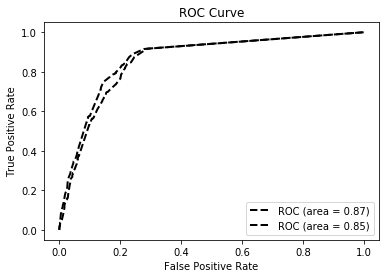

In [16]:
print('train ',model_metrics(gbm2,trainold_x, trainold_y))
print('test ',model_metrics(gbm2,test_x,test_y))

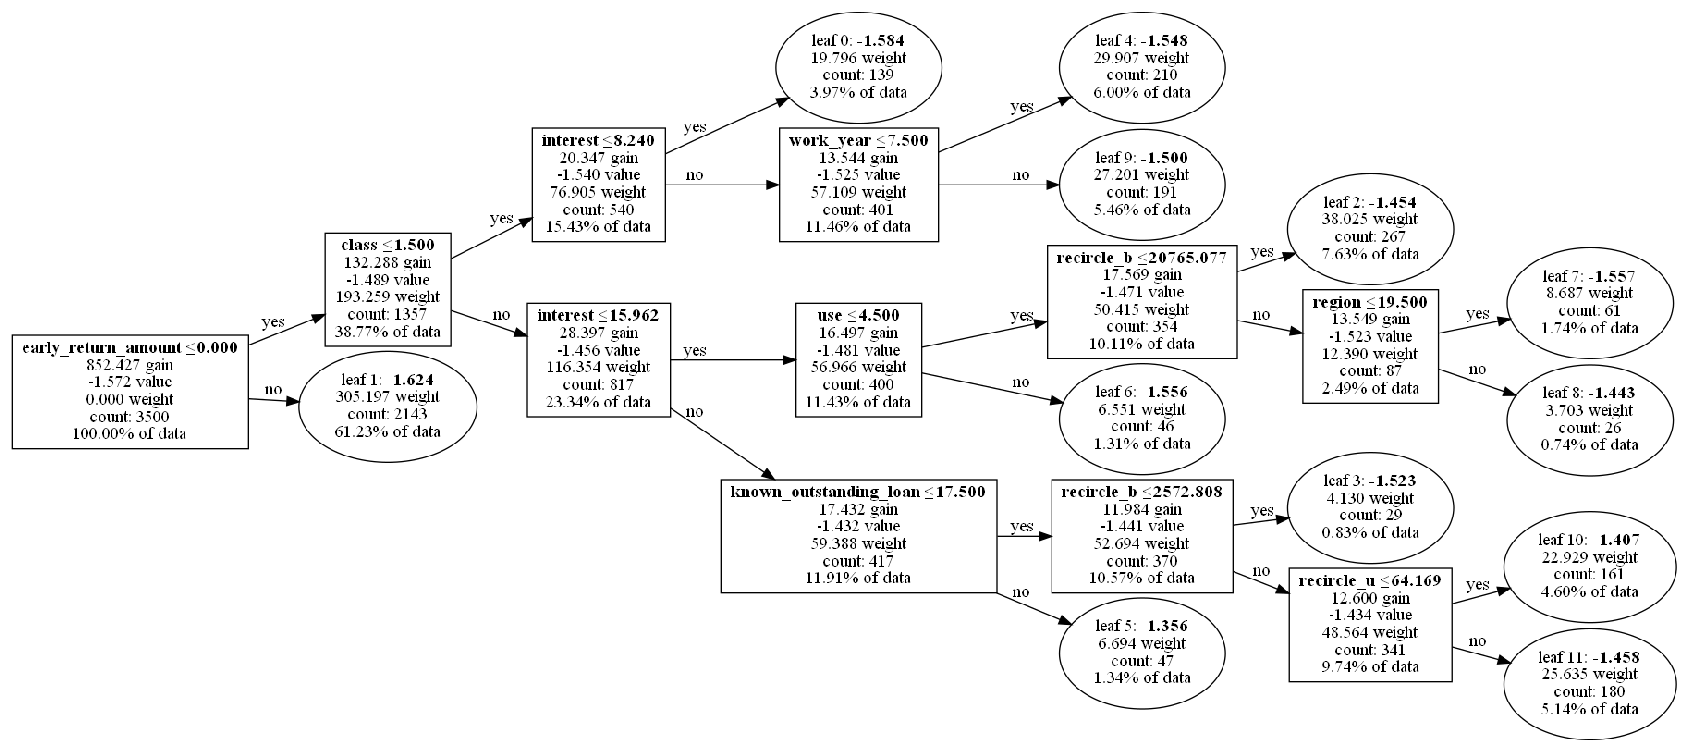

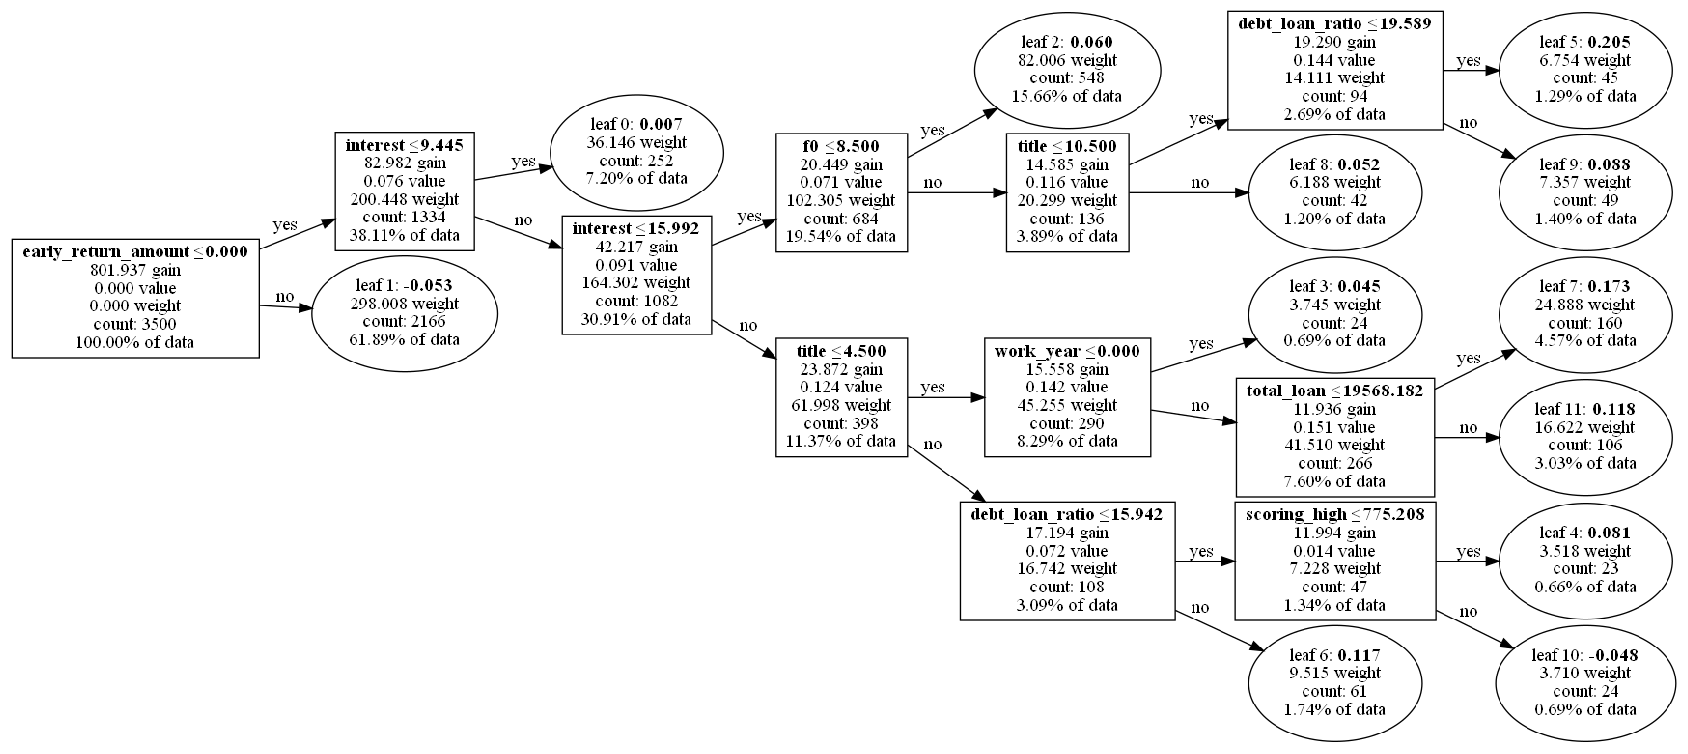

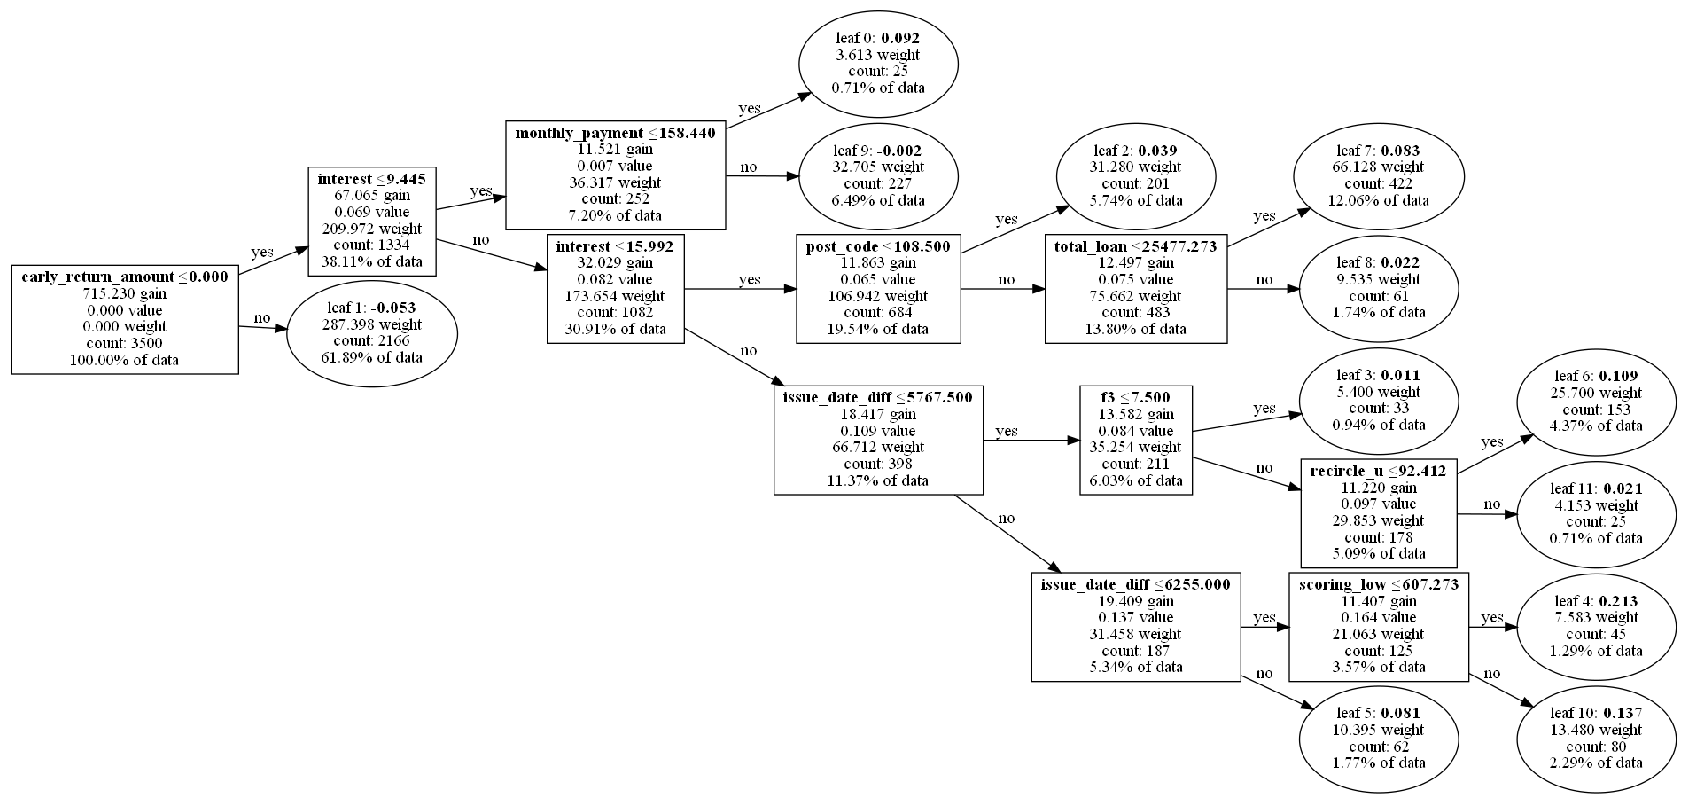

In [17]:
for k in range(num_boost_round+1):
    ax = lgb.plot_tree(gbm2, tree_index=k, figsize=(30,20), show_info=['split_gain','internal_value','internal_count','internal_weight','leaf_count','leaf_weight','data_percentage'])
plt.show()

In [18]:
###  xgbooost 增量学习  https://xgboost.readthedocs.io/en/latest/parameter.html
import xgboost as xgb
import pprint

xgb_params_01 = {}
# 增量学习的方法一
xgb_params_02 = {'process_type': 'default', # default, update
                 'refresh_leaf': True}  # 当前迭代树的结构不变，并在此增加新树
# 增量学习的方法二
xgb_params_02 = {'process_type': 'update', # default, update
                 'updater': 'refresh',
                 'refresh_leaf': True}  # 仅重新更新模型的叶节点权重，

dtrain_2class = xgb.DMatrix(train_x[num_feas], label=train_y,enable_categorical=True)
gbdt = xgb.train(xgb_params_01, dtrain_2class, num_boost_round=1) # 旧模型
pprint.pprint(gbdt.get_dump())
gbdt = xgb.train(xgb_params_02, dtrain_2class, num_boost_round=2, xgb_model=gbdt) # 更新模型
pprint.pprint(gbdt.get_dump())

['0:[early_return_amount<26] yes=1,no=2,missing=1\n'
 '\t1:[class<2] yes=3,no=4,missing=3\n'
 '\t\t3:[interest<8.23950005] yes=7,no=8,missing=7\n'
 '\t\t\t7:[f3<5.5] yes=15,no=16,missing=15\n'
 '\t\t\t\t15:[f2<13] yes=31,no=32,missing=31\n'
 '\t\t\t\t\t31:[recircle_u<32.7615395] yes=59,no=60,missing=59\n'
 '\t\t\t\t\t\t59:leaf=-0.0375000015\n'
 '\t\t\t\t\t\t60:leaf=0.100000009\n'
 '\t\t\t\t\t32:leaf=-0.120000005\n'
 '\t\t\t\t16:[use<6] yes=33,no=34,missing=33\n'
 '\t\t\t\t\t33:[scoring_low<875.45459] yes=61,no=62,missing=61\n'
 '\t\t\t\t\t\t61:leaf=-0.117735855\n'
 '\t\t\t\t\t\t62:leaf=0.0375000015\n'
 '\t\t\t\t\t34:[total_loan<8659.09082] yes=63,no=64,missing=63\n'
 '\t\t\t\t\t\t63:leaf=-0.0666666701\n'
 '\t\t\t\t\t\t64:leaf=0.120000005\n'
 '\t\t\t8:[issue_date_m<4] yes=17,no=18,missing=17\n'
 '\t\t\t\t17:[monthly_payment<95.8800049] yes=35,no=36,missing=35\n'
 '\t\t\t\t\t35:[post_code<405] yes=65,no=66,missing=65\n'
 '\t\t\t\t\t\t65:leaf=0.125\n'
 '\t\t\t\t\t\t66:leaf=-0.112500004\n'

XGBoostError: [15:33:33] C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:345: Check failed: model_.trees.size() < model_.trees_to_update.size() (1 vs. 1) : No more tree left for updating.  For updating existing trees, boosting rounds can not exceed previous training rounds